## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## My assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.


## Preparing the data

In [1]:
import pandas as pd
import boto3

In [3]:
bucket_name = 'sagemaker-studio-410838505498-ysxz63bqvz7'
file_key = 'mammographic_masses.data'

s3 = boto3.client('s3')
s3.download_file(bucket_name, file_key, 'mammographic_masses.data')

In [5]:
columns = ["BI_RADS", "age", "shape", "margin", "density", "severity"]
data = pd.read_csv("mammographic_masses.data", 
                   na_values="?",
                   names=columns)
df = pd.DataFrame(data)
df

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0
957,4.0,56.0,4.0,5.0,3.0,1
958,4.0,64.0,4.0,5.0,3.0,0
959,5.0,66.0,4.0,5.0,3.0,1


In [6]:
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [7]:
df_no_na = df.dropna()
df_no_na

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
10,5.0,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0
957,4.0,56.0,4.0,5.0,3.0,1
958,4.0,64.0,4.0,5.0,3.0,0
959,5.0,66.0,4.0,5.0,3.0,1


In [8]:
def drop_decimal_points(df):
    return df.map(lambda x: int(x) if isinstance(x, (int, float)) else x)


df_new = drop_decimal_points(df_no_na)
df_new

,BI_RADS,age,shape,margin,density,severity
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


In [9]:
import numpy as np
features = ["age", "shape", "margin", "density"]
arr_features = np.array(df_new[features])
arr_severity = np.array(df_new[["severity"]])
#arr_features
#print(arr_severity)


In [10]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
data_features = scaler.fit_transform(arr_features)
data_severity = scaler.fit_transform(arr_severity)


### Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [17]:
from sklearn.model_selection import train_test_split
X = arr_features
y = arr_severity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

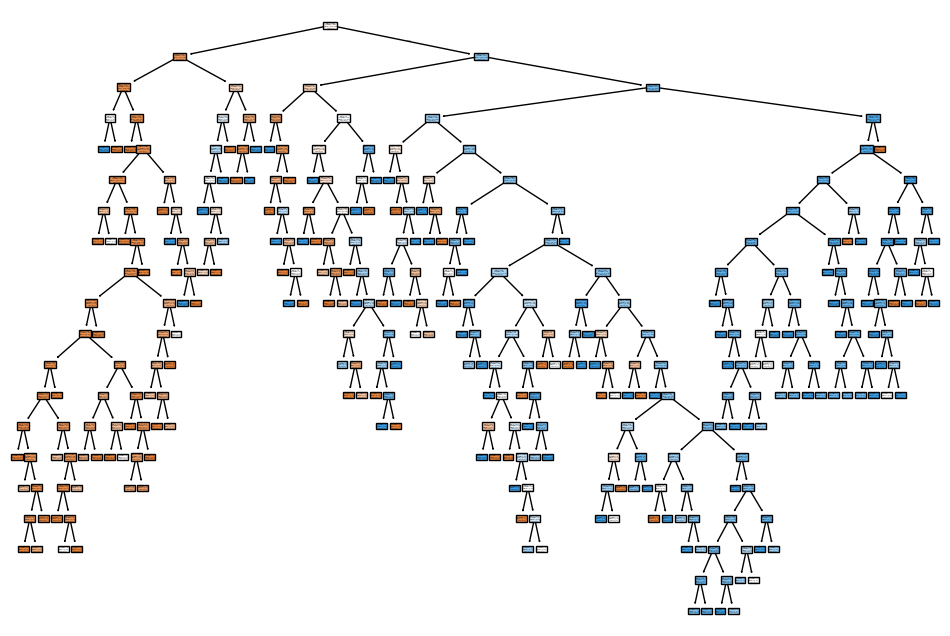

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

features = [str(f) for f in features]
arr_severity = [str(c) for c in arr_severity]  # Convert class names to strings if needed

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=features, class_names=arr_severity, filled=True)
plt.show()

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7403846153846154


In [24]:
from sklearn.model_selection import cross_val_score

k = 10
scores = cross_val_score(clf, X, y, cv=k)
print(scores)
kfold_avg = np.mean(scores)
print(kfold_avg)

[0.73493976 0.75903614 0.72289157 0.75903614 0.75903614 0.71084337
 0.73493976 0.75903614 0.77108434 0.68674699]
0.7397590361445782


Now I'll compare it to a Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)


clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7836538461538461


### SVM

Next I will try using svm.SVC with a linear kernel and see how it compares

In [27]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [30]:
X = arr_features
y = arr_severity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8173076923076923


### KNN

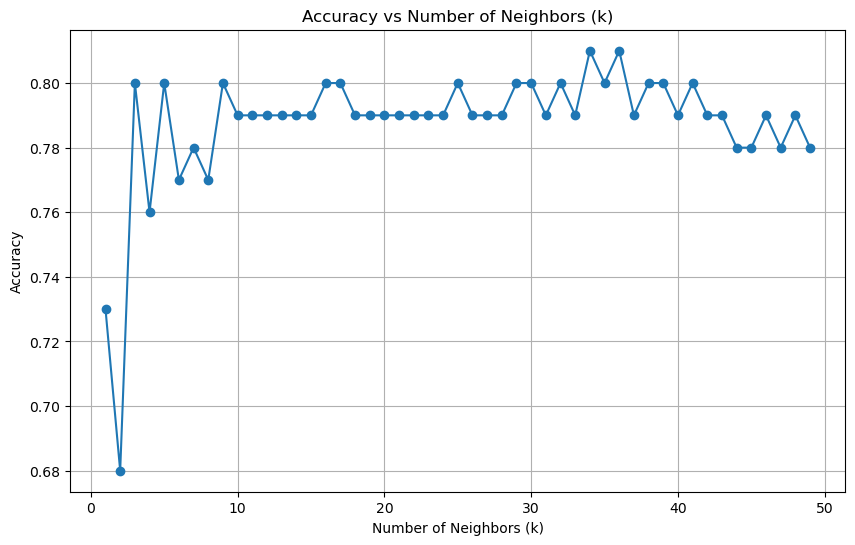

In [33]:
from sklearn.neighbors import KNeighborsClassifier
X = arr_features
y = arr_severity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

accs = {}
for k in range(1,50): 
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred),2)
    accs[k] = accuracy


plt.figure(figsize=(10, 6))
plt.plot(list(accs.keys()), list(accs.values()), marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Neighbors (k)")
plt.grid()
plt.show()


## Naive Bayes

Now try naive_bayes.MultinomialNB

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [40]:
from sklearn.preprocessing import MinMaxScaler
arr_features = np.array(df_new[features])
arr_severity = np.array(df_new[["severity"]])
scaler = MinMaxScaler()
X = np.array(scaler.fit_transform(arr_features))
y = np.array(scaler.fit_transform(arr_severity)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [41]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8028846153846154


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [44]:
X = arr_features
y = arr_severity.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='rbf'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8173076923076923


In [46]:
X = arr_features
y = arr_severity.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7259615384615384


In [48]:
X = arr_features
y = arr_severity.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='poly'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7836538461538461


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [50]:
from sklearn.linear_model import LogisticRegression

In [52]:
X = arr_features
y = arr_severity.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7788461538461539


## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better

In [53]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [54]:
import tensorflow as tf
print(tf.__version__)


2024-12-31 04:37:25.986297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5415 - loss: 0.6878 - val_accuracy: 0.6859 - val_loss: 0.6567
Epoch 2/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7694 - loss: 0.6448 - val_accuracy: 0.7436 - val_loss: 0.6220
Epoch 3/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7628 - loss: 0.6094 - val_accuracy: 0.7372 - val_loss: 0.5909
Epoch 4/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7966 - loss: 0.5690 - val_accuracy: 0.7436 - val_loss: 0.5627
Epoch 5/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7704 - loss: 0.5502 - val_accuracy: 0.7436 - val_loss: 0.5426
Epoch 6/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7533 - loss: 0.5421 - val_accuracy: 0.7436 - val_loss: 0.5313
Epoch 7/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7770 - loss: 0.4999 - val_accuracy: 0.7564 - val_loss: 0.5266
Epoch 8/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7855 - loss: 0.4780 - val_accuracy: 0.7500 - val_loss

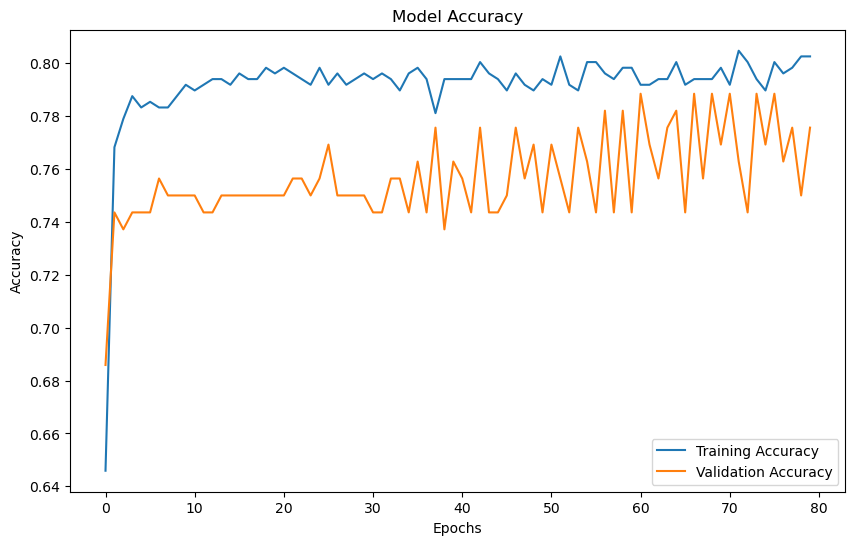

In [55]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(arr_features)  # Normalize features
y = np.array(arr_severity).ravel()  # Flatten target array

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.25, verbose=1)


y_pred = model.predict(X_test).flatten()
y_pred_classes = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_classes)

#print(f"Test Accuracy: {accuracy:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [56]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.85


## Results

The neural network performed the best when using Adam as the optimizer